### 1. Sekcja odczytywania danych, określania typów danych cech.

In [49]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score

target_var: str = "CO2 Emissions(g/km)" #To jest nazwa zmiennej docelowej.
target_var_discr: str = "CO2 Emissions(g/km)_disc" #To jest nazwa zmiennej docelowej, która została poddana proceowi dyskretyzacji.

dtypes = { "Make": "category", #Określ typ danych każdej cechy w ramce danych, która zostanie zaraz odczytana.
            "Model":"category",
            "Vehicle Class":"category",
            "Engine Size(L)":np.float64,
            "Cylinders":"category",
            "Transmission":"category",
            "Fuel Type":"category",
            "Fuel Consumption City (L/100 km)":np.float64,
            "Fuel Consumption Hwy (L/100 km)":np.float64,
            "Fuel Consumption Comb (L/100 km)":np.float64,
            "Fuel Consumption Comb (mpg)":np.float64,
            "CO2 Emissions(g/km)":np.float64}



def ReadDataFrame(filename:str, sep:str =';') -> tuple[pd.DataFrame, int]:
    global dtypes
   
    Dataset = pd.read_csv(filename,
                        sep=sep, dtype = dtypes, decimal = ",") #Wczytaj plik z danymi.

    n_rows:int  = Dataset.shape[0] #Liczba wszystkich wierszy w ramce danych

    return Dataset, n_rows




def FindTargetVarCol(Dataset:pd.DataFrame, target_var:str) -> np.ndarray:
    """Funkcja wybiera kolumne docelową z ramki danych, konwertuje ją na tablice numpy i zmienia liczbe jej wymiarów, tak
    aby zwrócona tablica była kompatybilna z modelami z sklearn'a."""

    return Dataset[target_var].to_numpy().reshape(-1,1)



Dataset, n_rows = ReadDataFrame("CO2Emission.csv")
target_var_col = FindTargetVarCol(Dataset, target_var)

n_splits = 15
train_size = 0.8
test_size  = 1 - train_size




### 2. Sekcja statystyki opisowej zmiennych kategorycznych

### Częstość występowania  unikatowych klas dla danej zmiennej.

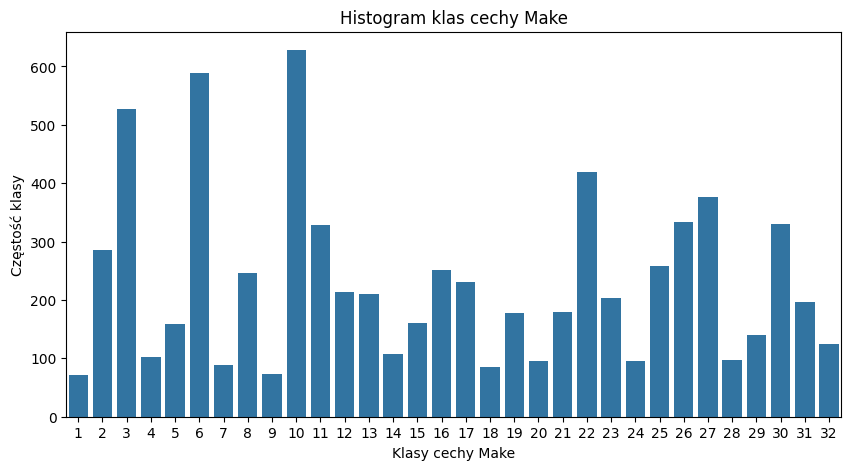

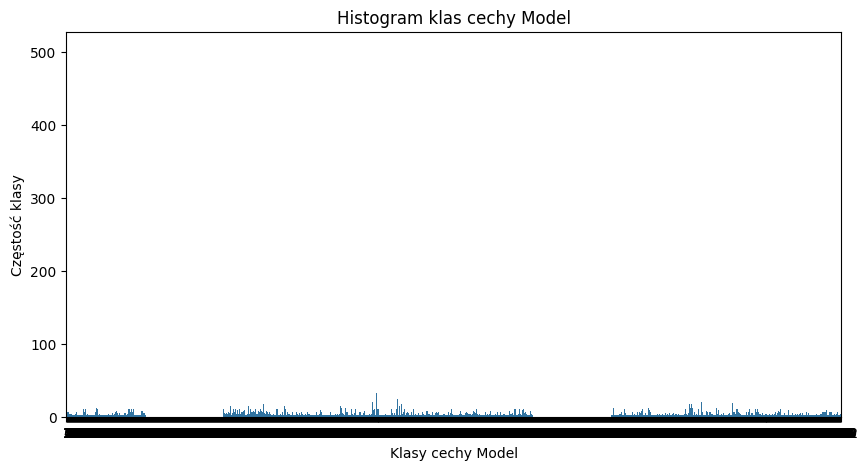

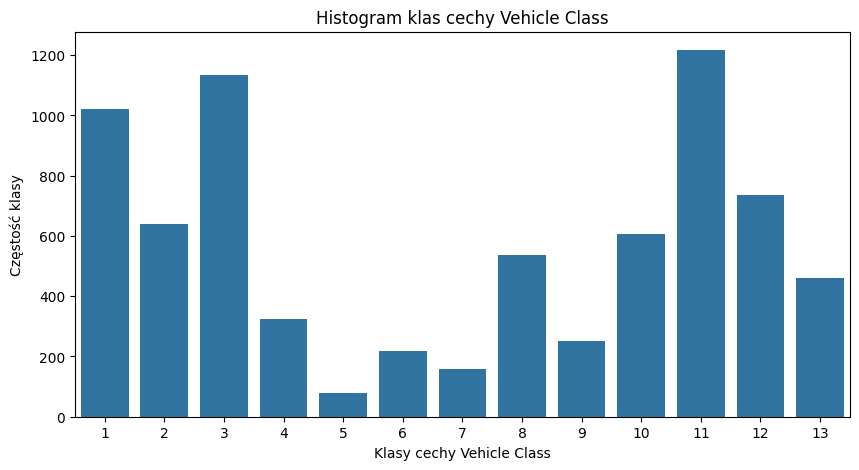

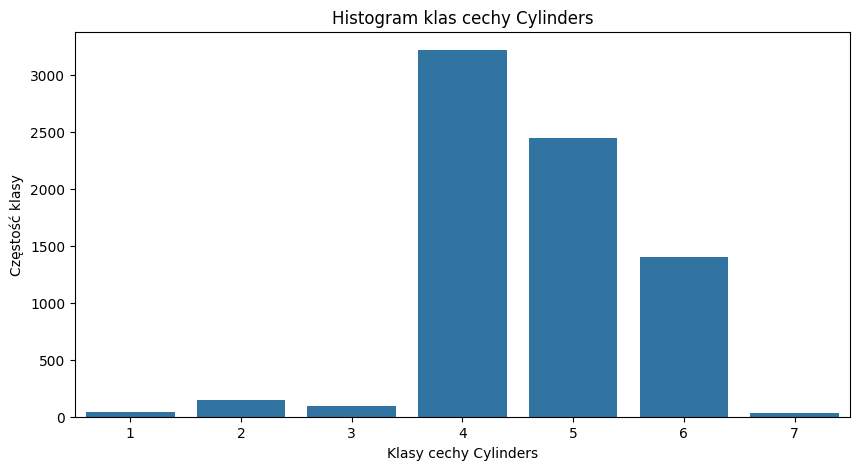

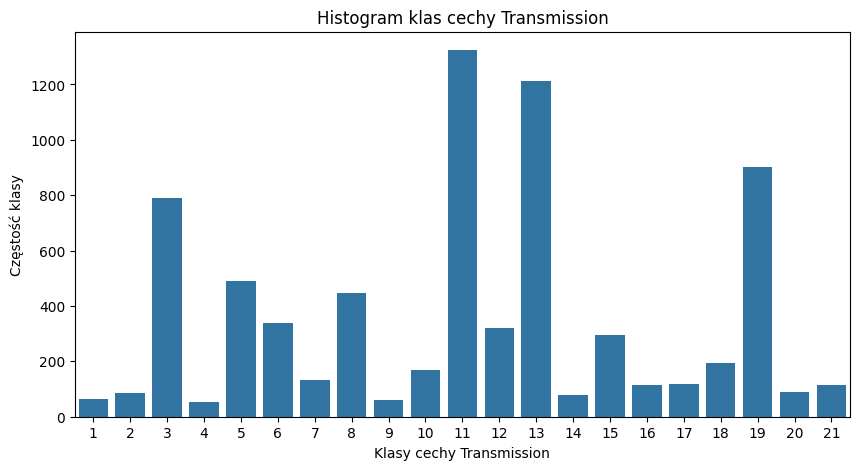

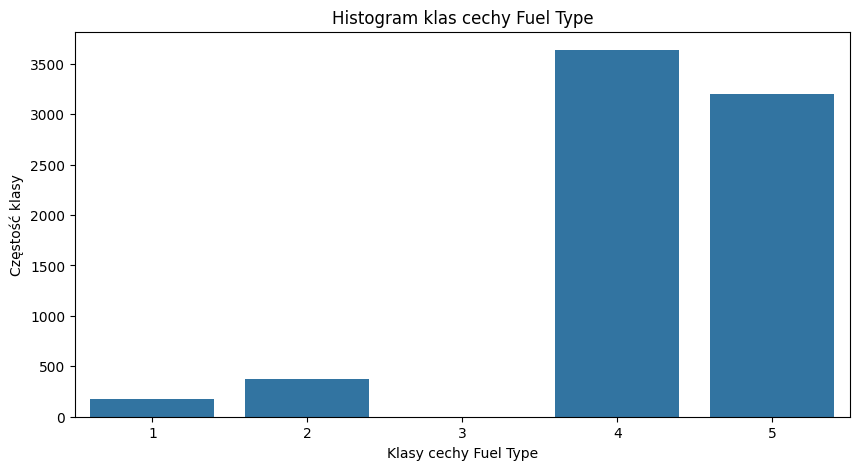

In [50]:
def CreateHistogram(Dataset:pd.DataFrame, CatFeature:str) ->  pd.DataFrame:
    """Funkcja dla każdej unikatowej klasy z cechy CatFeature wylicza liczbę jej wystapień.
    Wynikiem funkcji jest pandowska ramka danych, która zawiera trzy kolumny o nazwach odpowiednio: 'CatFeature', 'CatFeature_coded' oraz 'count'.
    Kolumna CatFeature_coded zawiera zakodowane nazwy klas w postaci liczb całkowitych. Taka forma ułatwia odczytywanie etykiet na wykresach.
    """

    Histogram:pd.DataFrame = Dataset[CatFeature].value_counts(sort = False,).reset_index() #Stwórz proste podsumowanie częstotliwości występowania klas.

    return  Histogram

def CreateHistPlot(Histogram:pd.DataFrame, CatFeature:str) -> None:

    """Zadaniem tej funkcji jest stworzenie wykresu histogramowego, który opisze częstowliwość występowania wszystkich klas z cechy 'CatFeature'"""
    plt.figure(figsize = (10,5)) #Stwórz płótno, na którym  będzie rysowany wykres
 
    axes = sns.barplot(data = Histogram, x = f"{CatFeature}_coded", y = "count") #Czas na słupkowanie.

    axes.set_xlabel(f"Klasy cechy {CatFeature}") #Ustaw etykietkę poziomej osi.
    axes.set_ylabel(f"Częstość klasy") #Ustaw etykietke pionowej osi.

    axes.set_title(f"Histogram klas cechy {CatFeature}") #Ustaw tytuł wykresu.

    axes.set_ylim(0, 1.05*np.max(Histogram['count']))

    

def AggregateRarestClass(Histogram:pd.DataFrame, CatFeature:str) -> pd.DataFrame:
    """Niektóre klasy danej cechy pojawią się bardzo rzadko. W tym celu niespotykane często klasy zagregujemy w jedną klasę o nazwie Other.
    Taki cel przyswięca funkcji tej. Klasa jest uznawana za rzadką, jeżeli liczba jej wystapień jest mniejsza niż frequency_threshold
    """
    frequecy_threshold:float = Histogram['count'].quantile(q = 0.25)

    Histogram[CatFeature] = Histogram.apply(func = lambda row: row[CatFeature] if row["count"]>=frequecy_threshold else "Other", 
                    axis = 1) #Klasy, które występują rzadziej niż frequency_threshold sklasyfikuj jako "other".
    

    Histogram:pd.DataFrame =   Histogram.groupby(by = CatFeature, 
                            as_index = False).agg(func = {"count":"sum"}) #Aktualnie w ramce Histogram tylko klasa "Other" może pojawiać się więcej 
                                                                            #Niż jeden raz. Zsumuj liczby wystąpień dla obserwacji, które są "inne".
    
    Unique_class_count:int = Histogram.shape[0]
    
    Histogram.insert(loc = 1, column = f"{CatFeature}_coded", value = range(1, Unique_class_count + 1 ))

    return Histogram


CatFeatures: list[str] = Dataset.select_dtypes(include = "category").columns #Znajdź listę wszystkich cech kategorycznych.

for CatFeature in CatFeatures:

    Histogram = CreateHistogram(Dataset = Dataset,  #Znajdź histogram unikatowych klas dla zmiennej CatFeature.
                                CatFeature = CatFeature) 


    Histogram = AggregateRarestClass(Histogram = Histogram, 
                                     CatFeature = CatFeature) #Zagreguj rzadkie klasy.
    

    CreateHistPlot(Histogram = Histogram,  #Rysuj wykresik, bo kochamy wykresy.
                  CatFeature = CatFeature)



Pierwsze wnioski, jakie można wysunąć:


### Zmienna make może zostać skasowana. Nie jest ona dobrą zmienną, którą można uwzględnić w modela, z powodu ogromnej liczby unikatowych klas (ponad 2000), co czyni ją niemalże zmienną identyfikującą.

### Obserwacja, której typ paliwa to 3, może zostać pominięta. Występuje nienormalnie rzadko.

### Kasujemy zmienną Model oraz obserwację, której cecha "Fuel Type" wynosi N

In [51]:
def DeleteFutileColsAndObs(Dataset:pd.DataFrame):

    Dataset.drop(columns = ["Model"], inplace = True)

    Dataset = Dataset.query('`Fuel Type` != "N"')

    return Dataset
    

Dataset = DeleteFutileColsAndObs(Dataset)


### 3. Cechy numeryczne ciągłe.

### Badanie zależności poziomu emisji dwutlenku węgla w zależności od wielkości spalania paliwa na autostradzie i w mieście dla różnych typów paliwa.
### Dodatkowo zbadamy współczynniki korelacji między tymi cechami ciągłymi.



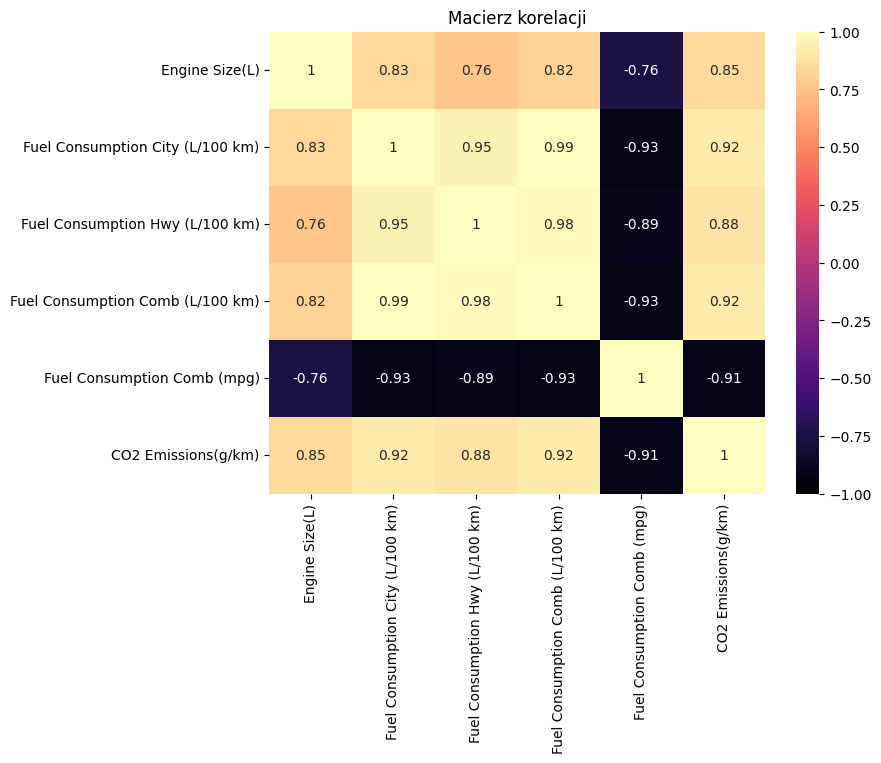

In [52]:
def FindContFeatures(Dataset) -> list[str]:
    """Funkcja zwracaa listę nagłówków cech, które są typu floating-point
    """
    return Dataset.select_dtypes(include = "float").columns.to_numpy()



def CreatePairPlotCont(Dataset:pd.DataFrame, ContFeatures:list[str]) -> None:
    """Utwórz wykres parowy. (to znaczy - dla par zmiennych ciągłych) warunkowy ze względu na typ paliwa.
    """

    sns.pairplot(data = Dataset, vars = ContFeatures, hue = "Fuel Type")



def ComputeAndDrawCorrelationMatrix(Dataset:pd.DataFrame, Num_Features: list[str]) -> np.array:
    """Funkcja ta zajmuje się liczeniem macierzy korelacji między cechami numerycznymi. Dodatkowo, rysuje wykres cieplny, który
    obrazuje te relacje.
    """
    CorrMatrix:pd.DataFrame =  Dataset[Num_Features].corr(method = "pearson")

    plt.figure(figsize=(8, 6))

    sns.heatmap(CorrMatrix, annot=True, cmap='magma', vmin=-1, vmax=1)
    plt.title('Macierz korelacji')
    plt.show()

    return CorrMatrix


ContFeatures = FindContFeatures(Dataset=Dataset)

#CreatePairPlotCont(Dataset, ContFeatures)
CorrMatrix = ComputeAndDrawCorrelationMatrix(Dataset, ContFeatures)

### 4. Dyskretyzacja zmiennej docelowej.

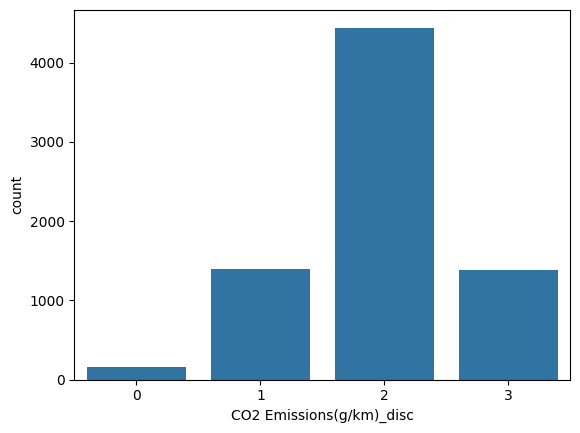

In [53]:
def Discretize(Dataset:pd.DataFrame, target_var:str, bins:list[float]) -> pd.Series:
    labels = [i for i in range(len(bins)+1)]
    bins = [-float("inf")] + bins + [float('inf')]


    discretized_feature = pd.cut(x = Dataset[target_var], 
                                 bins = bins, 
                                 labels = labels)


    Dataset[target_var_discr] = discretized_feature




Discretize(Dataset, target_var, [150, 200, 300])

def CreateHistPlotTarVar(Dataset:pd.DataFrame, target_var_discr:str):
    sns.barplot(data = Dataset[target_var_discr].value_counts().reset_index(), x = target_var_discr, y  = "count")

CreateHistPlotTarVar(Dataset, target_var_discr)


### 5. Warunkowe wykresy gęstości prawdopodobieństwa dla zmiennych ciągłych.

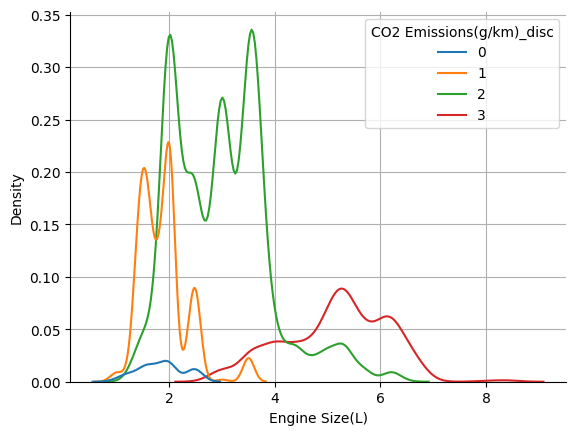

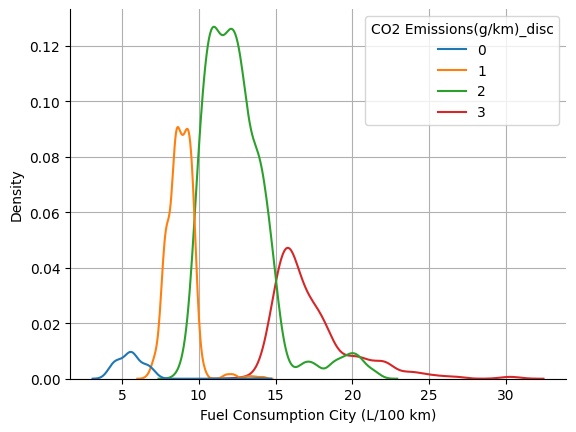

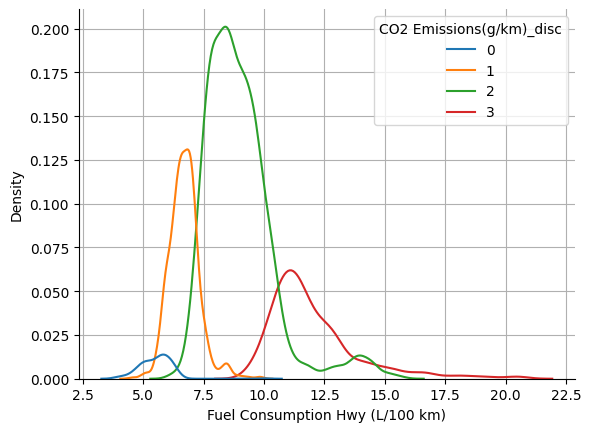

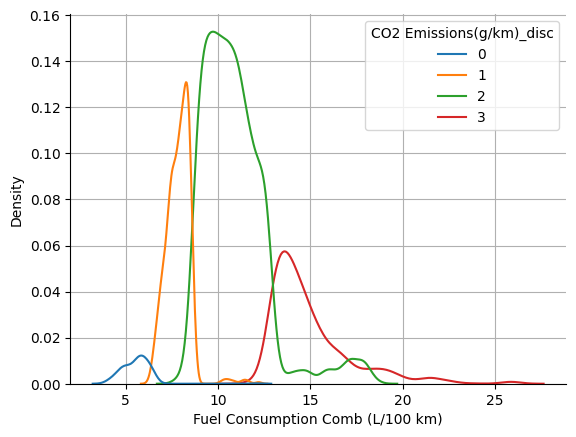

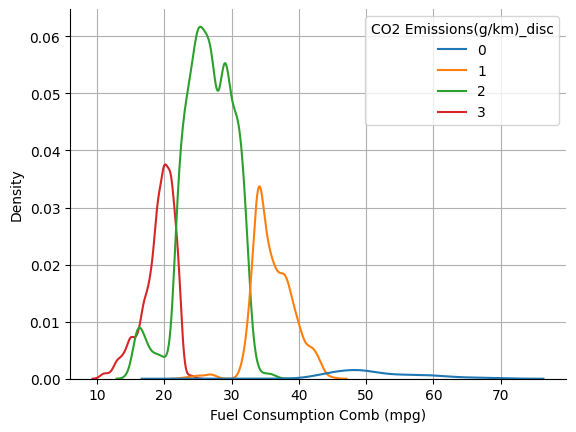

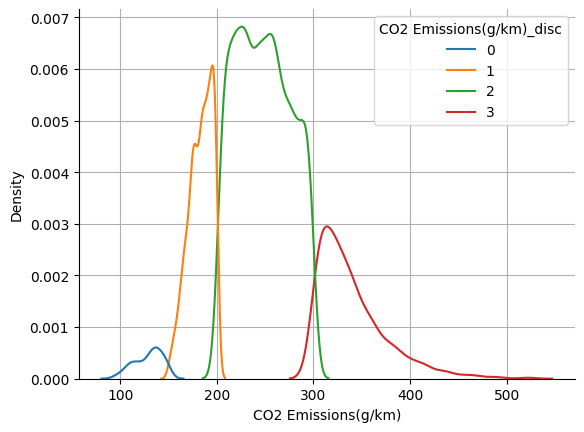

In [54]:
def StwórzWykresKDE(Dataset:pd.DataFrame, ContFeature:str, condfeature:str | None = None) -> plt.axes:
    okno = plt.figure(num  = f"{ContFeature}_kdeplot")
    osie  = okno.add_subplot()

    sns.kdeplot(data = Dataset, x = ContFeature, hue = condfeature, ax = osie) #Narysuj wykres warunkowy.

    osie.grid(True)
    osie.spines[["top","right"]].set_visible(False)

    return osie



for ContFeature in ContFeatures:    
    StwórzWykresKDE(Dataset, ContFeature, condfeature = target_var_discr)


### Dochodzimy do wniosku, że wszystkie cztery powyższe cechy ciągłe są bardzo dobrze dyskryminującę. Wykresy gęstości prawdopdoobieństwa dla każdej z cech ciągłych są praktycznie rozłączne, nie nachodzą na siebie.

### 6. Wykresy gęstości prawdopodobieństwa cia zmiennych ciągłych

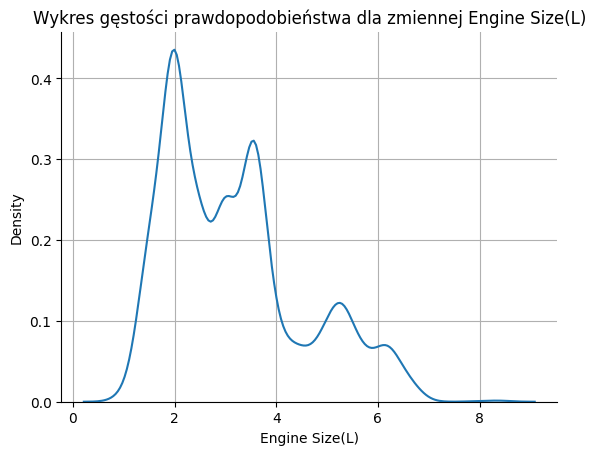

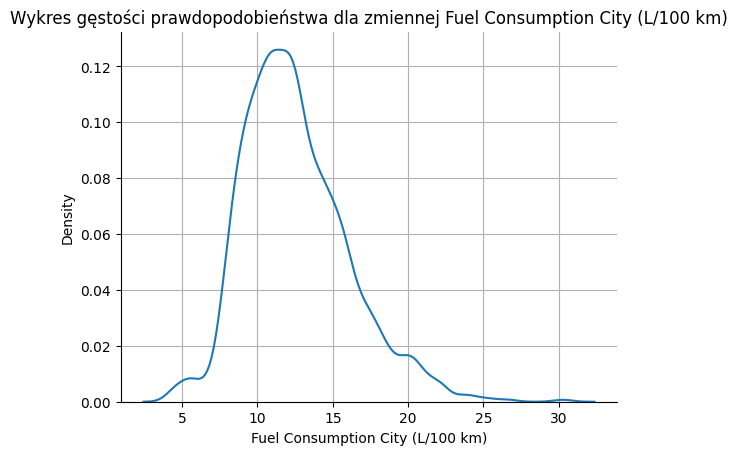

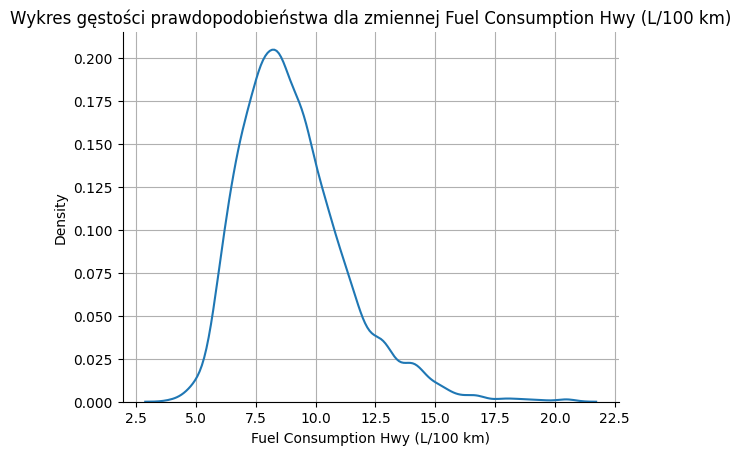

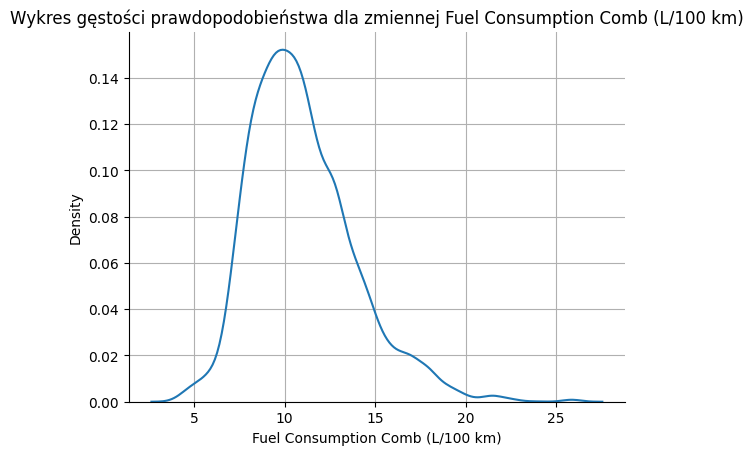

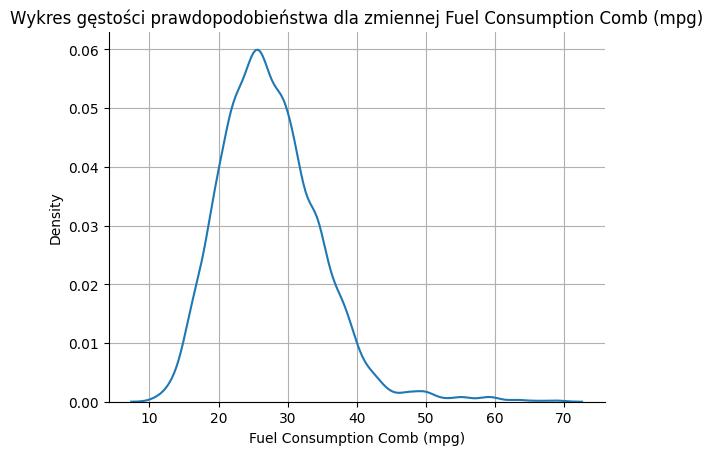

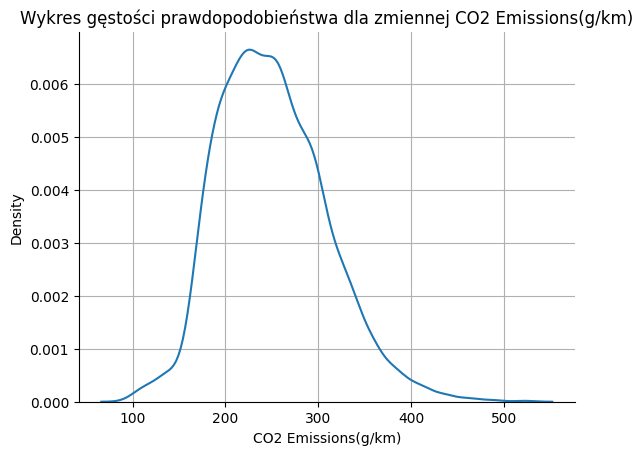

In [55]:
for ContFeature in ContFeatures:
    axes = StwórzWykresKDE(Dataset, ContFeature)
    axes.set_title(f"Wykres gęstości prawdopodobieństwa dla zmiennej {ContFeature}")

### Badanie relacji między zmiennymi ciągłymi.

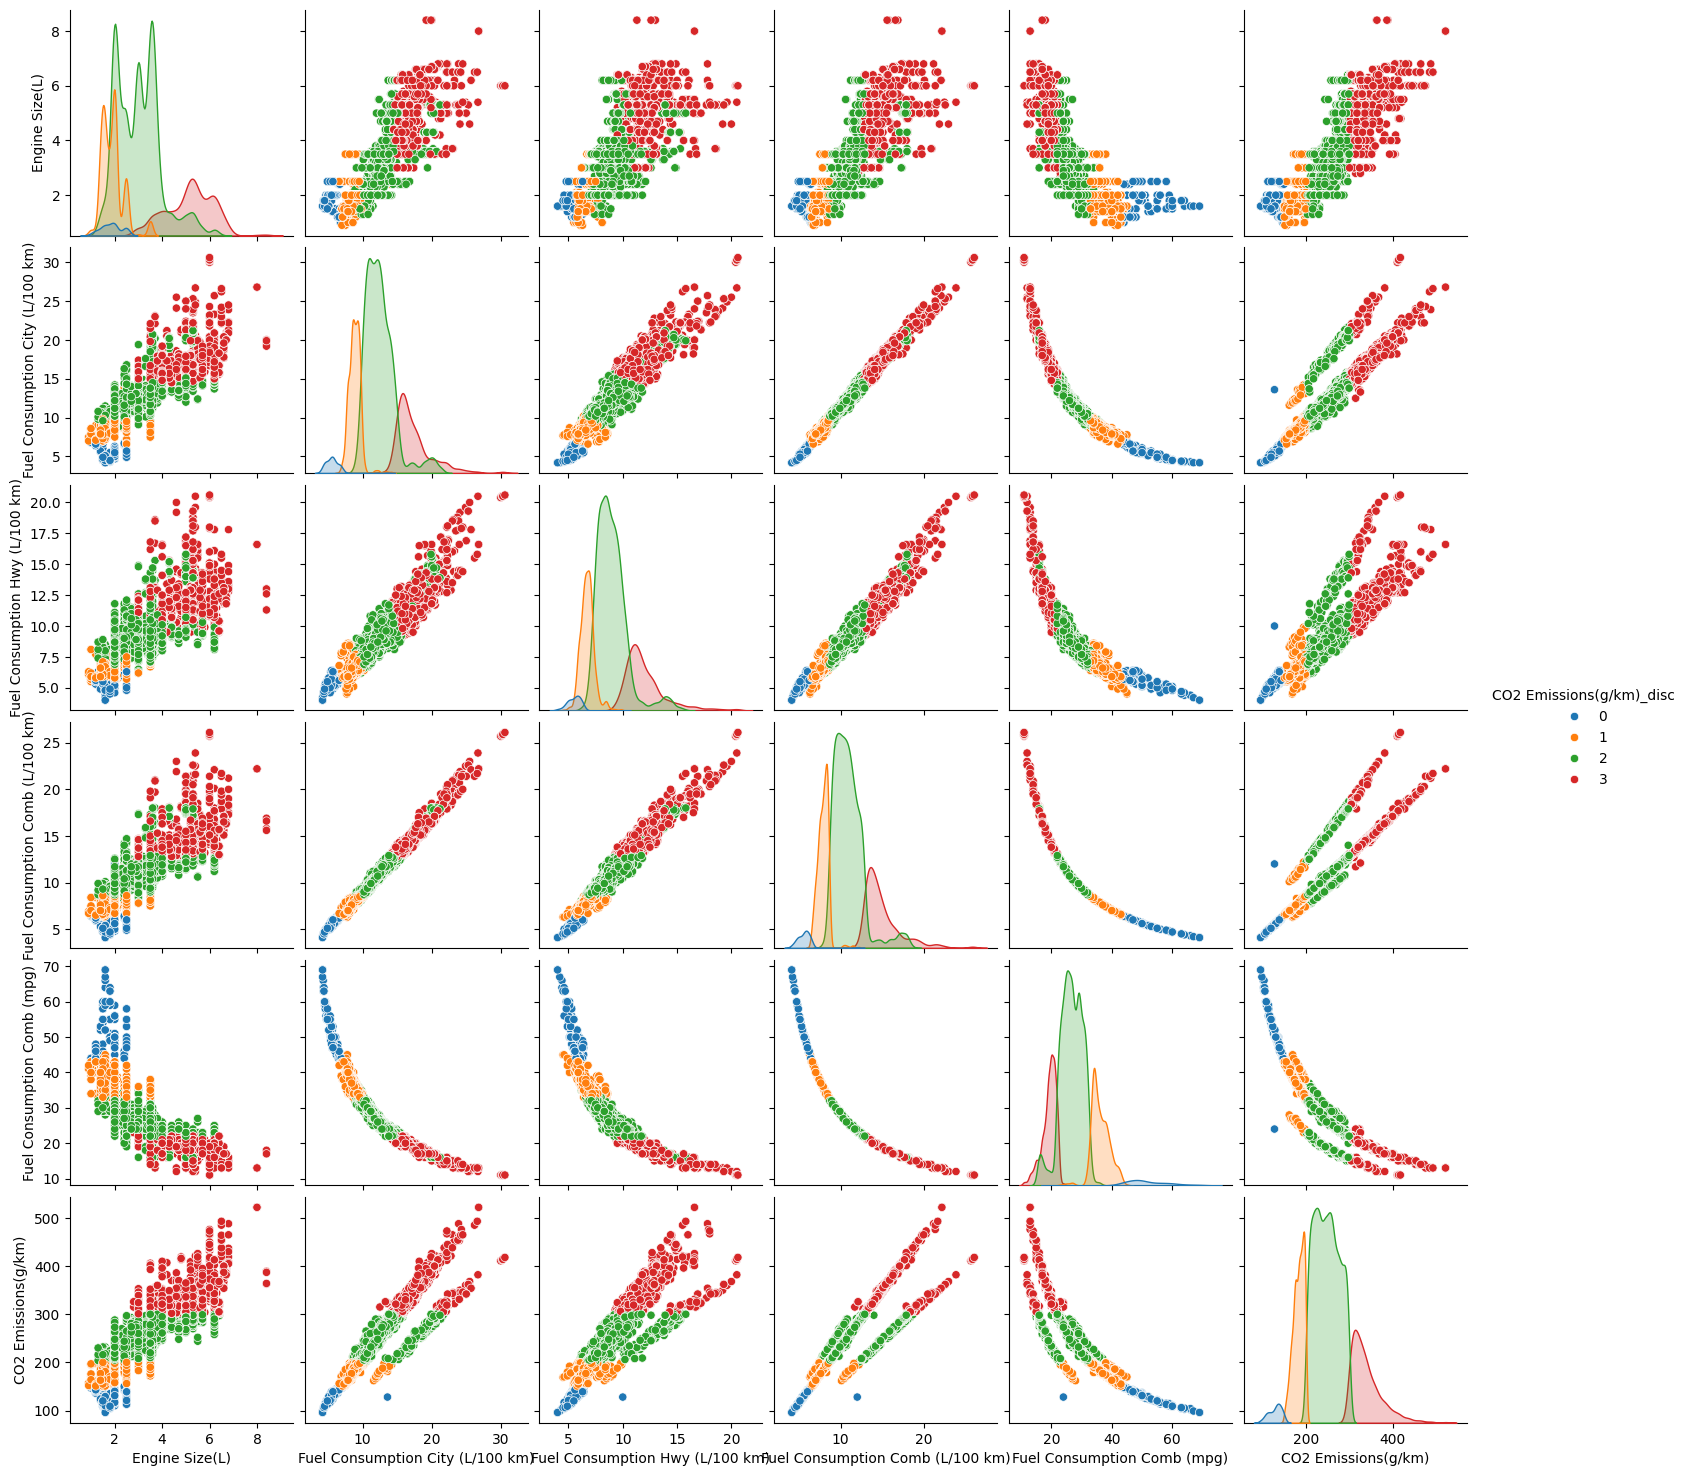

In [56]:
#Teraz stwórz wykres parowy warunkowy ze względu na dyskretną wartość zmiennej docelowej.
sns.pairplot(data = Dataset, vars = ContFeatures , hue = target_var_discr)


### 7. Wykresy pudełkowe dla zmiennych ciągłych.

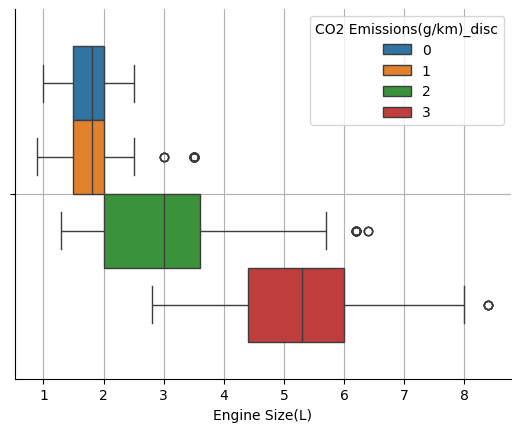

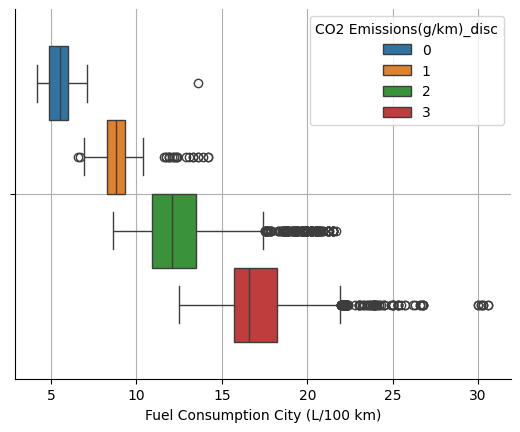

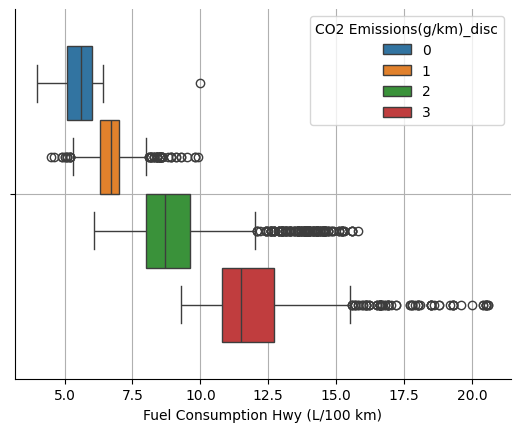

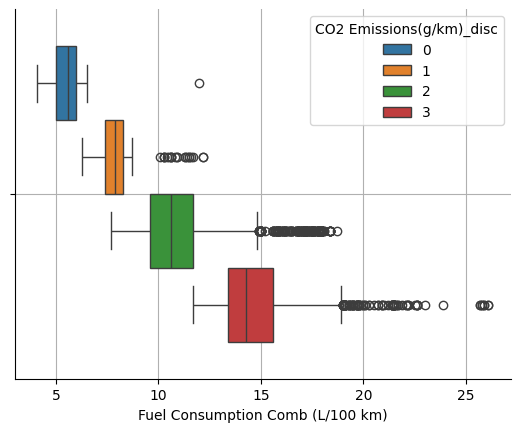

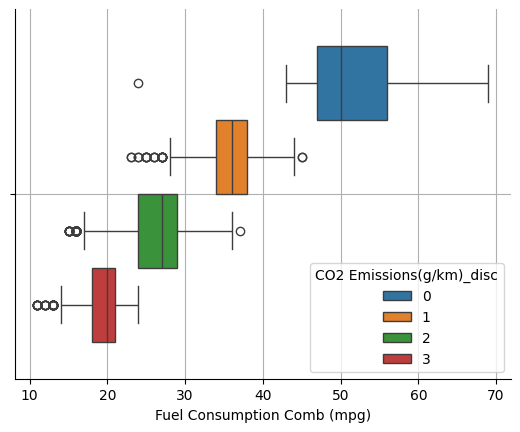

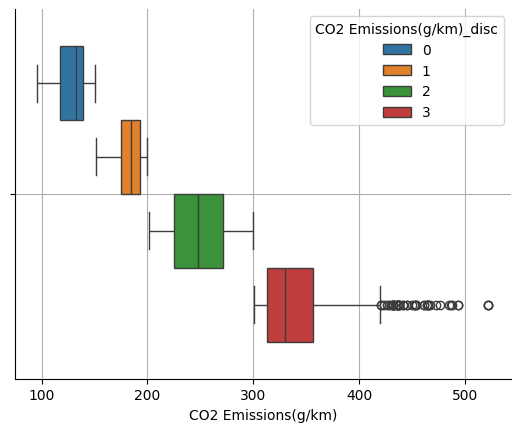

In [57]:
def StwórzWykresPudełkowy(Dataset:pd.DataFrame, ContFeature:str, condfeature:str):
    okno = plt.figure(num  = f"{ContFeature}_kdeplot")
    osie  = okno.add_subplot()

    sns.boxplot(data = Dataset, x = ContFeature, hue = condfeature, ax = osie) #Narysuj wykres pudełkowy..

    osie.grid(True)
    osie.spines[["top","right"]].set_visible(False)


for ContFeature in ContFeatures:
    
    StwórzWykresPudełkowy(Dataset, ContFeature, target_var_discr)

### Powyższe wykresy pudełkowe utwierdzają nas w przekoniu, że te zmienne idealnie spełniają wymagania na bycie predyktorem.

In [58]:
Predictors = ['Make', "Vehicle Class",'Engine Size(L)','Cylinders','Transmission','Fuel Type','Fuel Consumption City (L/100 km)']

num_predictors = [feature for feature in Predictors if dtypes[feature] is np.float64]
cat_predictors = [feature for feature in Predictors if dtypes[feature] == "category"]

### Analiza składowych głównych dla różnych typów zużycia paliwa.

### 8. Kodowanie zmiennych kategorycznych.

In [65]:
def ZakodujDane(Dataset:pd.DataFrame, CatFeatures:list[str], NumFeatures:list[str]) -> pd.DataFrame:
    #Zdefiniuj transformator. Jest on oparty na koderze OneHotEncoder(). Do przekształcenia bierzemy tylko kolumny kategoryczne. Pozostałe kolumny (zmienne ciągłe) są przekazywane 
    #do wyjściowej ramki zmiennych predykcyjnych bez zmian.
    cat_col_transformer = ColumnTransformer(transformers = 
                                            [('OHE',OneHotEncoder(sparse_output = False), CatFeatures)],
                                            remainder = "passthrough",)
    


    #Przekształć zmienną X za pomocą określonego wyżej transformatora. 
    X_coded = cat_col_transformer.fit_transform(X = Dataset)
    
    CatFeatures_coded = cat_col_transformer.named_transformers_["OHE"].get_feature_names_out(input_features = CatFeatures)

    Dataset_coded = pd.DataFrame(data = X_coded, columns =  np.concatenate((CatFeatures_coded, NumFeatures)))
    
    return Dataset_coded



def TransformujDane(X: np.ndarray,  numpredictors:list[str]) -> tuple[ np.ndarray, ColumnTransformer]:
    """Funkcja stosuje standaryzacje dla tablicy, która zawiera już zmienne numeryczne."""
    cont_col_transformer = ColumnTransformer(transformers = [("Scaler", StandardScaler(), numpredictors) ], remainder = "passthrough")


    return cont_col_transformer.fit_transform(X = X),  cont_col_transformer





### Definiowanie modeli, list na ich wyniki, na hiperparametry modeli.

In [66]:
# Definicja modeli z hiperparametrami
Models = {
    "DrzewkoDecyzyjne": DecisionTreeClassifier(criterion="gini", splitter="best", min_samples_split=10), 
    "LasLosowy": RandomForestClassifier(n_estimators=15, criterion='gini'), 
    "KNN": KNeighborsClassifier(n_neighbors=150),
    "RegresjaLiniowa": MultiOutputRegressor(estimator = LinearRegression())
}                 #Ewentualnie dodamy jeszcze regresje logistyczną

#Słownik do przechowywania hiperparametrów modeli:
Models_hipparams = {"DrzewkoDecyzyjne":{"criterion":['gini','entropy'],
                                        "splitter":['best','random'],
                                        "min_samples_split":[3,5],
                                        "min_samples_leaf":[2,3]},

                    "LasLosowy":{"n_estimators":list(range(1, 100, 20)),
                                 "criterion":['gini','entropy'],
                                        "min_samples_split":[3,5],
                                        "min_samples_leaf":[2,3]}
                                        ,
                    "KNN": {"n_neighbors":list(range(1, 10, 2)),
                            "p":[1,2]}}


def StworzTabelkePorównawczą() -> pd.DataFrame:
    global Models, n_splits


    Indeces = pd.MultiIndex.from_product( [list(Models.keys()), range(n_splits), ["True", "Pred"] ] #Stwórz  hierarchiczny system indeksów dla kolumn.
                                        ,names = ["Model", "iter_no", "array_type"]) #Nadaj poszczególnym poziomom wyjaśnialne i sensowne nazwy.


    return  pd.DataFrame(data = None, 
                                    columns = Indeces)


def ComputePerfomanceMetric(TruevsPrediction:pd.DataFrame, metric:'metric') -> pd.DataFrame:
    """Funkcja, na podstawie tabeli porównań etykiet prawdziwych i przewidywanych, oblicza pewną miarę dokładności dla wszystkich modeli i dla wszystkich  powtórzeń."""

    MetricsComparison = np.zeros(shape = [n_splits, len(Models.keys())], 
                                 dtype = np.float64)
    
    
    for model_indx, model in enumerate(Models.keys()):
        for i in range(n_splits):
            y_true = TruevsPrediction[(model, i, "True")]
            y_pred = TruevsPrediction[(model, i, "Pred")]

            perfomance_metric = metric(y_true, y_pred)

            MetricsComparison[i, model_indx] = perfomance_metric

    return pd.DataFrame(data = MetricsComparison, 
                                     columns = list(Models.keys()))



def TrainAndTestModel(Model, X_train:pd.DataFrame, y_train:pd.DataFrame, X_test:pd.DataFrame) -> np.ndarray:
    """Funkcja trenuje model za pomocą danyc treningowych (X_train, y_train), a następnie dokonuje predyckcji etykiet klasy docelowej i zwraca przewidywane etykietki.
    Jeżeli model jest regresją liniową, przewidziane etykietki są tablicą wymiaru (n_test, n_outputs), gdzie n_outputs to liczba klas emisji.
    W przeciwnym wypadku  etykietki są wymiaru (n_test, 1)"""
    Model.fit(X = X_train, #Znajdź optymalne parametry dla danego Modelu, eksponując model na dane treningowe.
              y = y_train) \

    return Model.predict(X_test) # Dokonaj przewidywań etykietki klas. Nie zwracamy od razu metryki dokładności. Przewidziane etykietki pomogą nam metrykę policzyć oraz ułatwią
                                 #stworzenie macierzy pomyłek. \



### Przygotowanie metody porównaczej.

In [67]:
def PlotlineScores(perfomance_df: pd.DataFrame, metric_name:"str", n_splits:int):
    """Stwórz wykresy liniowe obrazujące dynamikę zmian dokładności modeli."""

    figure = plt.figure()
    axes = figure.add_subplot()
    
    x_values = list(range(0,n_splits))

    for model_name in Models.keys():
        axes.plot(x_values, perfomance_df[model_name])

    axes.legend(list(Models.keys()))

    axes.set_title(f"Dynamika zmian metryki {metric_name} dla modeli")

    axes.set_xlabel("Numer iteracji")
    axes.set_ylabel(f"{metric_name}")

    axes.set_xticks(x_values)



def MacierzPomylek(model_name:str, y_true:np.ndarray, y_predicted: np.ndarray):
    """Funkcja ta wylicza macierz pomyłek dla  danego modelu."""
    axes = plt.figure(num = f"{model_name}_conf_matrix").add_subplot()


    cos = ConfusionMatrixDisplay.from_predictions(y_true = y_true, y_pred = y_predicted, ax = axes)
    axes.set_title(f"ConfMatrix dla  modelu {model_name}")


def PlotConfussionMatrices(TrueVSPrediction:pd.DataFrame, n_splits:int):
    """Funkcja wylicza macierze pomyłek dla wszystkich modeli, a następnie obrazuje te macierze na wykresie."""
    
    for model_name in Models.keys():
        y_true = TrueVSPrediction[(model_name, 0, "True")]
        y_pred = TrueVSPrediction[(model_name, 0, "Pred")]
        
        MacierzPomylek(model_name, y_true, y_pred)



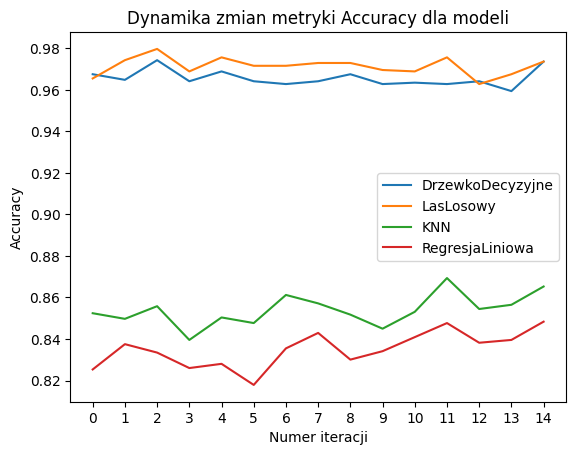

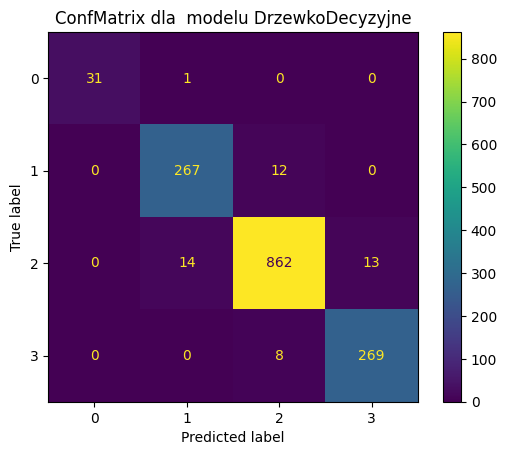

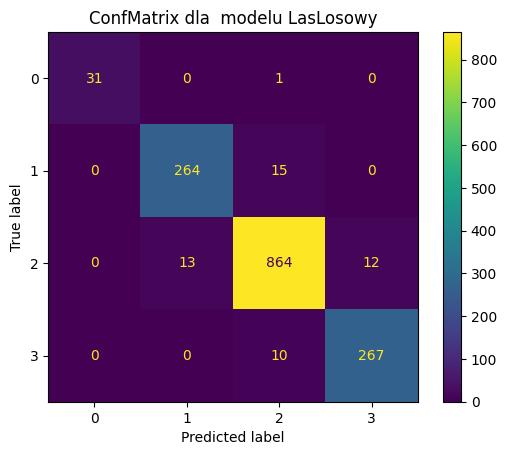

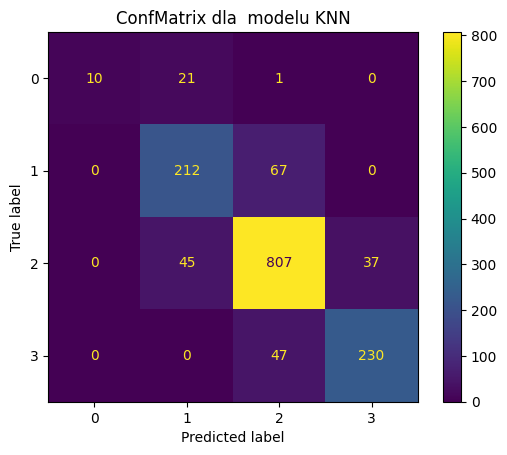

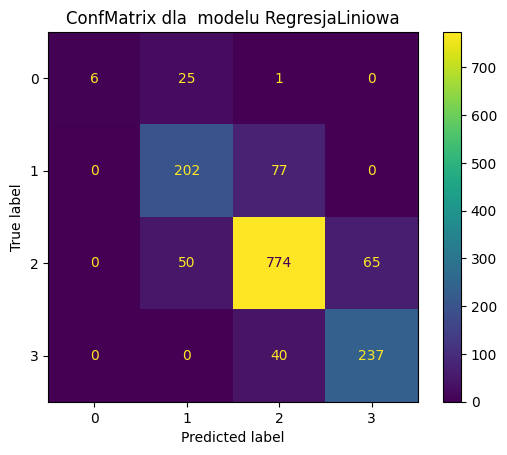

In [69]:
def PorównajStatycznie(Dataset:pd.DataFrame,CatPredictors:list[str], NumPredictors:list[str], 
                       n_splits:int = 5, train_size:float = 0.8, test_size:float =  0.2):
    
    TrueVSPrediction_df = StworzTabelkePorównawczą()

    
    X = Dataset[cat_predictors + num_predictors] #Zainicjuj ostateczny zbiór predyktorów.

    y = Dataset[[target_var_discr]] #Zdefiniuj zmienną celu (jest to wieloklasowa zmienna kategoryczna)
    y_OHE = OneHotEncoder(sparse_output = False).fit_transform(X = y) #Zakoduj zmienną docelową jako zbiór k kolumn binarnych. Tak zakodowana etykietka przyda się w wielowyjściowej regresji.


    X_coded = ZakodujDane(X, cat_predictors, num_predictors)

    SSS = StratifiedShuffleSplit(n_splits = n_splits,  #Zdefiniuj stratyfikowany podział szufladkowy.
                                 train_size =train_size, 
                                 test_size = test_size)
    

    for iter_indx, indx in enumerate(SSS.split(X, y)): #Wydobadź indeksy treningowe i testowe.
        train_indx, test_indx = indx
        X_train, y_train = X_coded.iloc[train_indx, :],  np.array(y.iloc[train_indx,: ]).ravel()
        X_test, y_test = X_coded.iloc[test_indx, :],  np.array(y.iloc[test_indx, :]).ravel()


        X_train ,Scaler = TransformujDane(X_train, num_predictors)
        
        X_test = Scaler.transform(X_test)

     

        for model_name in Models.keys():
            model:'Estimator' = Models[model_name] #Zrekrutuj motel.

            if model_name != "RegresjaLiniowa":
                y_predicted:np.ndarray = TrainAndTestModel(model, X_train, y_train, X_test) #Etykietki przewidziane.
                
                TrueVSPrediction_df[(model_name, iter_indx, "True")] = y_test
                TrueVSPrediction_df[(model_name, iter_indx,"Pred")] = y_predicted

            else:
                #Regresja liniowa niestety ma wielowymiarowe-wyjście.
                y_OHE_train = y_OHE[train_indx]
                y_OHE_test = y_OHE[test_indx]

                y_predicted: np.ndarray = TrainAndTestModel(model, X_train, y_OHE_train, X_test).argmax(axis = 1)

                TrueVSPrediction_df[(model_name, iter_indx, "True")] = y_OHE_test.argmax(axis = 1)
                TrueVSPrediction_df[(model_name, iter_indx, "Pred")] = y_predicted


    return TrueVSPrediction_df


TrueVSPrediction_df_stat = PorównajStatycznie(Dataset, cat_predictors, num_predictors, n_splits = n_splits) #Dokonaj 

Accuracy_comparison = ComputePerfomanceMetric(TrueVSPrediction_df_stat, accuracy_score) #Wylicz tabele porównawczą

PlotlineScores(Accuracy_comparison, "Accuracy", n_splits) #Narysuj wykresy liniowe obrazujące zmiany dokładności modeli.

PlotConfussionMatrices(TrueVSPrediction_df_stat, n_splits)